# Train and Compare Machine Learning Models
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import train and test data
* Run many ML algorithms using SageMaker Autopilot
* Run many ML algorithms using H2O AutoML
* Compare all model performance in test dataset
* Choosing and save the best model

# 1. Parameters

In [2]:
#Name
ModelName = 'hr_analytics'
#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

#Setting the model target variable name
VarTarget = 'is_promoted'
VarId = 'employee_id'
VarDate = 'reference_date'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

# ATENÇÃO: nome do bucket criado no S3 (altere para o bucket com o seu nome)
bucket = 'aula-deploy-modelos-mateusmessias'

CAT = [
'department'
,'education'
,'kpis_met_80'
,'no_of_trainings'
,'previous_year_rating']

#float
#Testar as variaveis no_of_trainings e previous_year_rating como categorcias e ver se melhora o modelo
NUM = [
'age'
,'length_of_service'
,'avg_training_score']

selected_features = CAT + NUM

# 2. Import Libraries

In [3]:
try:
    import sys
    sys.path.append('/var/lang/lib/python37.zip')
    sys.path.append('/var/lang/lib/python3.7')
    sys.path.append('/var/lang/lib/python3.7/lib-dynload')
    sys.path.append('/var/lang/lib/python3.7/site-packages')
    sys.path.remove('/opt/.sagemakerinternal/conda/lib/python3.7/site-packages')
except:
    pass

In [4]:
import functools
import os
from time import gmtime, strftime, sleep
import datetime as dt
import pandas as pd
import numpy as np
import glob
import boto3
import awswrangler as wr
import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer
import h2o
import matplotlib.pyplot as plt
from sklearn import metrics
import shutil
import seaborn as sns
from io import StringIO
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 3. Importing Data for Modeling

In [5]:
#Criar conexão com o Athena
my_boto3_session = boto3.Session(region_name='us-east-1')

In [6]:
query4="select * from auladeploymodelos.%s" % ModelName
dataprep_df_full = wr.athena.read_sql_query(query4, database="aula-deploy-modelos", boto3_session=my_boto3_session)

In [7]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    dataprep_df = dataprep_df_full.copy()
else:
    dataprep_df = dataprep_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del dataprep_df_full

In [8]:
#Numeric features must be float type
for col_name in NUM:
    dataprep_df[col_name] = dataprep_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

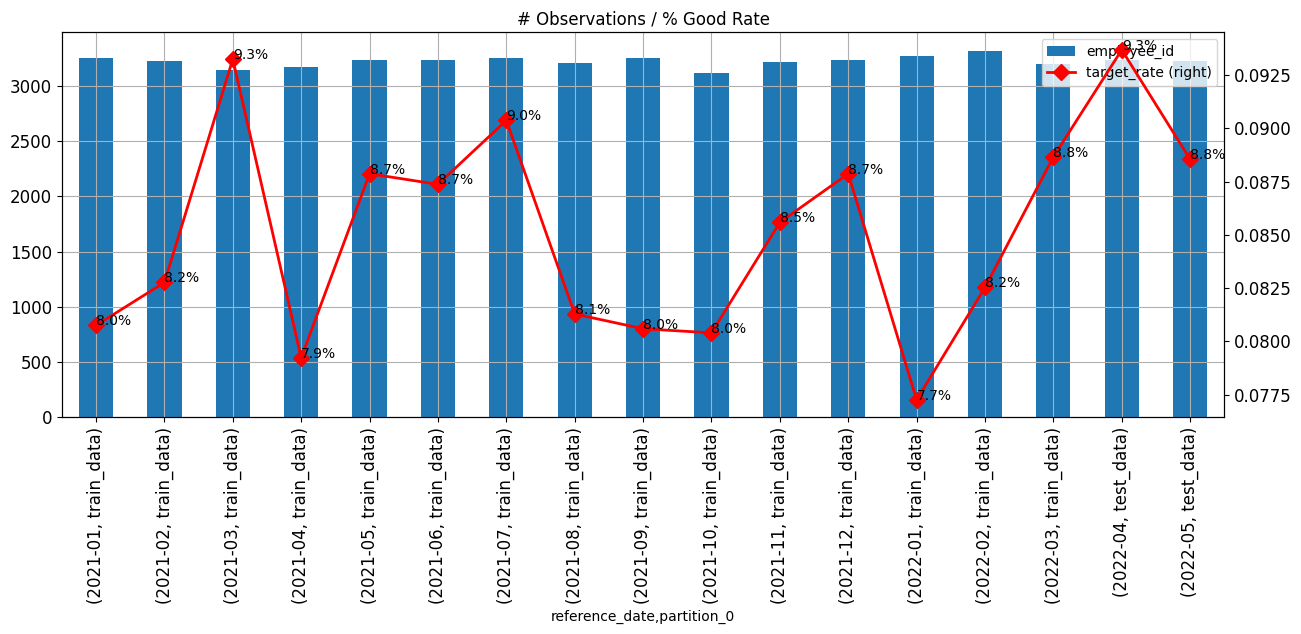

In [9]:
#plot the final dataset with time period, train and test definitions
dataprep_target = dataprep_df[[VarDate, VarId, VarTarget, 'partition_0']].groupby(by=[VarDate, 'partition_0']).agg({VarId:'count', VarTarget:'sum'})
dataprep_target['target_rate'] = dataprep_target[VarTarget] / dataprep_target[VarId]


dataprep_target[VarId].plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Observations / % Good Rate"))
ax = dataprep_target.target_rate.plot(secondary_y=True, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)
for p in range(len(dataprep_target)):
    ax.annotate(str('{0:.1%}'.format(int(dataprep_target.reset_index().iloc[p,4]*1000)/1000)), (dataprep_target.reset_index().index.values[p], dataprep_target.reset_index().iloc[p,4]*1))

## 3.1 Treatment of Numeric Missing Data

In [10]:
#Create the "Missing" category for missing values in string vaviables
# dataprep_df = dataprep_df.apply(lambda x: x.fillna(np.nan) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

In [11]:
#Tratamento da idade
# dataprep_df['age_mean'] = dataprep_df['age'].fillna(dataprep_df['age'].mean())

## 3.2 Outliers Removing

In [12]:
# var = 'max_salary_offered_to_prev_application'

# q_low = dataprep_df[var].quantile(0.00012)
# q_hi  = dataprep_df[var].quantile(0.9999)
# print('Low: ' + str(q_low))
# print('High: ' + str(q_hi))
# print('Reduction: ' 
#       + "{0:.2%}".format(len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])/len(dataprep_df)-1) 
#       + " | " 
#       + str(len(dataprep_df)-len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])))

# def plot_comparison(x, title, low, high):
#     fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
#     fig.suptitle(title, fontsize=16)
#     sns.distplot(x.rename(""), ax=ax[0])
#     ax[0].set_title('Histogram + KDE')
#     sns.boxplot(x.rename(""), ax=ax[1])
#     ax[1].set_title('Boxplot')
#     sns.violinplot(x.rename(""), ax=ax[2])
#     ax[2].set_title('Violin plot')
#     # only one line may be specified; full height
#     ax[1].axvline(x = low, color = 'red')
#     ax[1].axvline(x = high, color = 'red')
#     plt.show()
    
# plot_comparison(dataprep_df[var], var, q_low, q_hi)

# dataprep_df = dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)]

# 4. Modeling

## 4.1 Traning Models with SageMaker Autopilot

### 4.1.1 SageMaker Setup

In [13]:
# region = my_boto3_session.region_name
# session = sagemaker.Session(my_boto3_session)

# # You can modify the following to use a bucket of your choosing
# prefix = "models/%s/sagemaker-temp" % ModelName

# role = get_execution_role()

# # # This is the client we will use to interact with SageMaker AutoPilot
# sm = my_boto3_session.client(service_name="sagemaker", region_name=region)

# input_data_config = [
#     {
#         "DataSource": {
#             "S3DataSource": {
#                 "S3DataType": "S3Prefix",
#                 "S3Uri": 's3://%s/databases/%s/train_data/train_data.csv' % (bucket, ModelName),
#             }
#         },
#         "TargetAttributeName": 'Survived',
#     }
# ]

# output_data_config = {"S3OutputPath": "s3://%s/%s" % (bucket, prefix)}

### 4.1.2 SageMaker Setup and Run Auto Pilot

In [14]:
# timestamp_suffix = strftime("%d-%H-%M-%S", gmtime())

# auto_ml_job_name = "autopilot-" + ModelName.replace('_', '-')[0:10] + '-' + timestamp_suffix
# print("AutoMLJobName: " + auto_ml_job_name)

# #Run SageMaker Autopilot
# sm.create_auto_ml_job(
#     AutoMLJobName=auto_ml_job_name,
#     InputDataConfig=input_data_config,
#     OutputDataConfig=output_data_config,
#     AutoMLJobConfig={"CompletionCriteria": {"MaxCandidates": 3}},
#     RoleArn=role
# )

In [15]:
# print("JobStatus - Secondary Status")
# print("------------------------------")

# describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
# print(describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"] + " - " + strftime("%d-%H-%M-%S", gmtime()))
# job_run_status = describe_response["AutoMLJobStatus"]

# while job_run_status not in ("Failed", "Completed", "Stopped"):
#     describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
#     job_run_status = describe_response["AutoMLJobStatus"]

#     print(
#         describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"] + " - " + strftime("%d-%H-%M-%S", gmtime())
#     )
#     sleep(30)

### 4.1.3 Create SageMaker Endpoint and Predictor with the Best Candidate

In [16]:
# #Select best candidate
# best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)["BestCandidate"]
# best_candidate_name = best_candidate["CandidateName"]

# #Add probability and probabilities to the SAGEMAKER_INFERENCE_OUTPUT
# for i in range(len(best_candidate["InferenceContainers"])):
#     best_candidate["InferenceContainers"][i]['Environment']['SAGEMAKER_INFERENCE_INPUT']='predicted_label, probability, probabilities'
#     best_candidate["InferenceContainers"][i]['Environment']['SAGEMAKER_INFERENCE_OUTPUT']='predicted_label, probability, probabilities'

# #Create endpoint configuration
# timestamp_suffix = strftime("%d-%H-%M-%S", gmtime())
# model_name = best_candidate_name + timestamp_suffix + "-model"
# model_arn = sm.create_model(
#     Containers=best_candidate["InferenceContainers"], ModelName=model_name, ExecutionRoleArn=role
# )

# epc_name = best_candidate_name + timestamp_suffix + "-epc"
# ep_config = sm.create_endpoint_config(
#     EndpointConfigName=epc_name,
#     ProductionVariants=[
#         {
#             "InstanceType": "ml.m5.2xlarge",
#             "InitialInstanceCount": 1,
#             "ModelName": model_name,
#             "VariantName": "main",
#         }
#     ],
# )

# #Create end endpoint
# ep_name = best_candidate_name + timestamp_suffix + "-ep"
# create_endpoint_response = sm.create_endpoint(EndpointName=ep_name, EndpointConfigName=epc_name)
# sm.get_waiter("endpoint_in_service").wait(EndpointName=ep_name)
# print("ep_name: " + str(ep_name))

In [17]:
# #Create Predictor
# sm_predictor = Predictor(
#     endpoint_name=ep_name,
#     sagemaker_session=session,
#     serializer=CSVSerializer(),
#     deserializer=CSVDeserializer(),
# )

## 4.2 Traning Models with H2O AutoML

## 4.2.1 Creating context and H2O and Importing data into the H2O context

In [18]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = '4G')
# h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_342"; OpenJDK Runtime Environment Corretto-8.342.07.4 (build 1.8.0_342-b07); OpenJDK 64-Bit Server VM Corretto-8.342.07.4 (build 25.342-b07, mixed mode)
  Starting server from /var/lang/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpi1pjz4d3
  JVM stdout: /tmp/tmpi1pjz4d3/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpi1pjz4d3/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/GMT
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,4 months and 9 days !!!
H2O_cluster_name:,H2O_from_python_unknownUser_nkd4xo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.556 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [19]:
#Import TRAINING base to the H20 context
data_hdf = h2o.H2OFrame(dataprep_df.query('partition_0 == "train_data"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
data_hdf[VarTarget] = data_hdf[VarTarget].asfactor()
for col_name in CAT:
    data_hdf[col_name] = data_hdf[col_name].asfactor()
for col_name in NUM:
    data_hdf[col_name] = data_hdf[col_name].asnumeric()
    
# Partition data into 90%, 10% chunks
# Setting a seed will guarantee reproducibility
train_hdf, valid_hdf = data_hdf.split_frame(ratios=[0.90], destination_frames=['train_hdf', 'valid_hdf'], seed=1)
        
#Notice that `split_frame()` uses approximate splitting not exact splitting (for efficiency), so these are not exactly 90%, 10% of the total rows.
print('Training: ' + str(train_hdf.nrow))
print('Validation: ' + str(valid_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training: 43448
Validation: 4896


In [20]:
#Import TEST base to the H20 context
test_hdf = h2o.H2OFrame(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
test_hdf[VarTarget] = test_hdf[VarTarget].asfactor()
for col_name in CAT:
    test_hdf[col_name] = test_hdf[col_name].asfactor()
for col_name in NUM:
    test_hdf[col_name] = test_hdf[col_name].asnumeric()
    
print('Test: ' + str(test_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Test: 6464


## 4.2.2 Train the H2O Champion algorithm with new data

In [21]:
# h2o_champion = h2o.load_model('StackedEnsemble_BestOfFamily_3_AutoML_1_20220713_190002')
# h2o_champion

In [22]:
## This is the champion previous trained algorithms that will be used as comparison for the new experiments
vModel='h2o_champion_'

#Execution time of the model
start = dt.datetime.now()

from h2o.estimators.gbm import H2OGradientBoostingEstimator
h2o_champion = H2OGradientBoostingEstimator(model_id='%s%s_%s' % (vModel, ModelId, str(dt.datetime.now())[:19].replace('-',"").replace(':',"").replace(' ',"_")),
                                    nfolds= 5,
                                    keep_cross_validation_models= False,
                                    keep_cross_validation_predictions= True,
                                    keep_cross_validation_fold_assignment= False,
                                    score_each_iteration= False,
                                    score_tree_interval= 5,
                                    fold_assignment='Modulo',
                                    fold_column= None,
                                    ignore_const_cols= True,
                                    offset_column= None,
                                    weights_column= None,
                                    balance_classes= False,
                                    class_sampling_factors= None,
                                    max_after_balance_size= 5.0,
                                    max_confusion_matrix_size= 20,
                                    ntrees= 120,
                                    max_depth= 4,
                                    min_rows= 100.0,
                                    nbins= 20,
                                    nbins_top_level= 1024,
                                    nbins_cats= 1024,
                                    r2_stopping= 1.7976931348623157e+308,
                                    stopping_rounds= 2,
                                    stopping_metric='AUCPR',
                                    stopping_tolerance= 0.002303474948339114,
                                    max_runtime_secs= 31688.0,
                                    seed= 101,
                                    build_tree_one_node= False,
                                    learn_rate= 0.1,
                                    learn_rate_annealing= 1.0,
                                    distribution='bernoulli',
                                    quantile_alpha= 0.5,
                                    tweedie_power= 1.5,
                                    huber_alpha= 0.9,
                                    checkpoint= None,
                                    sample_rate= 0.9,
                                    sample_rate_per_class= None,
                                    col_sample_rate= 0.4,
                                    col_sample_rate_change_per_level= 1.0,
                                    col_sample_rate_per_tree= 0.7,
                                    min_split_improvement= 1e-05,
                                    histogram_type='UniformAdaptive',
                                    max_abs_leafnode_pred= 1.7976931348623157e+308,
                                    pred_noise_bandwidth= 0.0,
                                    categorical_encoding='Enum',
                                    calibrate_model= False,
                                    calibration_frame= None,
                                    custom_metric_func= None,
                                    custom_distribution_func= None,
                                    export_checkpoints_dir= None,
                                    monotone_constraints= None,
                                    check_constant_response= True,
                                    gainslift_bins= -1,
                                    auc_type='AUTO',
                                    interaction_constraints= None)

# The use of a validation_frame is recommended with using early stopping
h2o_champion.train(x=selected_features, y=VarTarget, training_frame=train_hdf, validation_frame=valid_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")
print(h2o_champion)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%

Execution time: 0:00:14.489859

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  h2o_champion_hr_analytics_v1_20221118_000149


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,28.0,28.0,6585.0,4.0,4.0,4.0,11.0,16.0,14.107142




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.05963668017345495
RMSE: 0.2442062246820399
LogLoss: 0.2123009224974074
Mean Per-Class Error: 0.30806247336962506
AUC: 0.8718480376222665
AUCPR: 0.4747557070129553
Gini: 0.743696075244533

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15819856333969234: 


,,0,1,Error,Rate
0,0,37266.0,2533.0,0.0636,(2533.0/39799.0)
1,1,2016.0,1633.0,0.5525,(2016.0/3649.0)
2,Total,39282.0,4166.0,0.1047,(4549.0/43448.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.158199,0.417914,195.0
1,max f2,0.107877,0.551816,261.0
2,max f0point5,0.317173,0.531394,119.0
3,max accuracy,0.317173,0.931205,119.0
4,max precision,0.933934,1.000000,0.0
5,max recall,0.022747,1.000000,383.0
6,max specificity,0.933934,1.000000,0.0
7,max absolute_mcc,0.317173,0.409012,119.0
8,max min_per_class_accuracy,0.120549,0.776075,243.0
9,max mean_per_class_accuracy,0.099938,0.799849,271.0



Gains/Lift Table: Avg response rate:  8.40 %, avg score:  8.44 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010012,0.534567,11.633104,11.633104,0.977011,0.753565,0.977011,0.753565,0.116470,0.116470,1063.310370,1063.310370,0.116219
1,2,0.020001,0.289077,8.971270,10.303719,0.753456,0.405071,0.865362,0.579519,0.089614,0.206084,797.127046,930.371863,0.203144
2,3,0.031601,0.247330,3.709070,7.882959,0.311508,0.261865,0.662054,0.462915,0.043025,0.249109,270.907011,688.295908,0.237451
3,4,0.040071,0.214624,3.300261,6.914301,0.277174,0.230365,0.580701,0.413760,0.027953,0.277062,230.026094,591.430146,0.258720
4,5,0.050014,0.196917,2.563275,6.049302,0.215278,0.206829,0.508053,0.372621,0.025486,0.302549,156.327457,504.930210,0.275689
5,6,0.100074,0.155642,3.065665,4.556797,0.257471,0.170566,0.382705,0.271547,0.153467,0.456015,206.566498,355.679733,0.388576
6,7,0.150018,0.140264,2.096040,3.737552,0.176037,0.147555,0.313900,0.230267,0.104686,0.560702,109.603995,273.755162,0.448337
7,8,0.200447,0.133157,1.744450,3.236130,0.146508,0.136987,0.271788,0.206800,0.087969,0.648671,74.445022,223.612951,0.489320
8,9,0.300543,0.113749,1.837084,2.770174,0.154288,0.124005,0.232654,0.179225,0.183886,0.832557,83.708410,177.017389,0.580792
9,10,0.400249,0.063226,1.107675,2.356031,0.093029,0.094636,0.197872,0.158153,0.110441,0.942998,10.767544,135.603109,0.592512




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.06315554846303083
RMSE: 0.2513076768883729
LogLoss: 0.22221088763172442
Mean Per-Class Error: 0.32211437319697145
AUC: 0.8628820858371781
AUCPR: 0.451508374508902
Gini: 0.7257641716743561

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15962812047597374: 


,,0,1,Error,Rate
0,0,4175.0,291.0,0.0652,(291.0/4466.0)
1,1,249.0,181.0,0.5791,(249.0/430.0)
2,Total,4424.0,472.0,0.1103,(540.0/4896.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.159628,0.401330,152.0
1,max f2,0.090533,0.561210,254.0
2,max f0point5,0.337340,0.519481,66.0
3,max accuracy,0.337340,0.927492,66.0
4,max precision,0.892151,1.000000,0.0
5,max recall,0.027402,1.000000,369.0
6,max specificity,0.892151,1.000000,0.0
7,max absolute_mcc,0.337340,0.400744,66.0
8,max min_per_class_accuracy,0.119606,0.770936,213.0
9,max mean_per_class_accuracy,0.082624,0.803158,262.0



Gains/Lift Table: Avg response rate:  8.78 %, avg score:  8.48 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010008,0.520908,11.153678,11.153678,0.979592,0.721212,0.979592,0.721212,0.111628,0.111628,1015.367822,1015.367822,0.111404
1,2,0.020425,0.296970,8.037209,9.564279,0.705882,0.405970,0.840000,0.560439,0.083721,0.195349,703.720930,856.427907,0.191766
2,3,0.030433,0.249879,3.020788,7.412393,0.265306,0.267212,0.651007,0.464009,0.030233,0.225581,202.078785,641.239270,0.213938
3,4,0.040033,0.215241,2.422563,6.215852,0.212766,0.234423,0.545918,0.408955,0.023256,0.248837,142.256309,521.585192,0.228909
4,5,0.050041,0.199258,3.717893,5.716260,0.326531,0.208605,0.502041,0.368885,0.037209,0.286047,271.789274,471.626009,0.258729
5,6,0.100082,0.157185,2.834893,4.275577,0.248980,0.171799,0.375510,0.270342,0.141860,0.427907,183.489321,327.557665,0.359389
6,7,0.150123,0.141262,2.044841,3.531998,0.179592,0.148670,0.310204,0.229785,0.102326,0.530233,104.484101,253.199810,0.416708
7,8,0.200163,0.133707,1.719525,3.078880,0.151020,0.137472,0.270408,0.206706,0.086047,0.616279,71.952539,207.887992,0.456181
8,9,0.300041,0.113077,2.002454,2.720560,0.175869,0.124281,0.238938,0.179269,0.200000,0.816279,100.245399,172.055979,0.565943
9,10,0.400123,0.066613,1.278026,2.359742,0.112245,0.096365,0.207249,0.158532,0.127907,0.944186,27.802563,135.974216,0.596448




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.061205790201030924
RMSE: 0.2473980400104878
LogLoss: 0.2178212732473265
Mean Per-Class Error: 0.31213035555736635
AUC: 0.8585929028914279
AUCPR: 0.44531760185722413
Gini: 0.7171858057828557

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1536065844472971: 


,,0,1,Error,Rate
0,0,36615.0,3184.0,0.08,(3184.0/39799.0)
1,1,1986.0,1663.0,0.5443,(1986.0/3649.0)
2,Total,38601.0,4847.0,0.119,(5170.0/43448.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.153607,0.391478,203.0
1,max f2,0.087204,0.532563,287.0
2,max f0point5,0.293882,0.497760,120.0
3,max accuracy,0.332558,0.929019,109.0
4,max precision,0.943031,1.000000,0.0
5,max recall,0.022151,1.000000,384.0
6,max specificity,0.943031,1.000000,0.0
7,max absolute_mcc,0.293882,0.378716,120.0
8,max min_per_class_accuracy,0.117322,0.761703,252.0
9,max mean_per_class_accuracy,0.077851,0.788171,294.0



Gains/Lift Table: Avg response rate:  8.40 %, avg score:  8.43 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010012,0.512859,11.523616,11.523616,0.967816,0.724847,0.967816,0.724847,0.115374,0.115374,1052.361567,1052.361567,0.115022
1,2,0.020001,0.282302,7.764127,9.646034,0.652074,0.361199,0.810127,0.543232,0.077555,0.192930,676.412703,864.603446,0.188784
2,3,0.030013,0.238680,4.051057,7.779612,0.340230,0.258538,0.653374,0.448261,0.040559,0.233489,305.105729,677.961186,0.222132
3,4,0.040025,0.216841,3.257269,6.648376,0.273563,0.228537,0.558367,0.393299,0.032612,0.266100,225.726904,564.837602,0.246803
4,5,0.050037,0.202354,2.655085,5.849350,0.222989,0.208068,0.491260,0.356235,0.026583,0.292683,165.508484,484.935042,0.264893
5,6,0.100005,0.157750,2.681915,4.266726,0.225242,0.174140,0.358343,0.265251,0.134009,0.426692,168.191471,326.672604,0.356640
6,7,0.150203,0.143287,2.085468,3.537746,0.175149,0.149507,0.297119,0.226569,0.104686,0.531378,108.546845,253.774614,0.416124
7,8,0.200009,0.134684,1.821238,3.110298,0.152957,0.138980,0.261220,0.204757,0.090710,0.622088,82.123783,211.029804,0.460778
8,9,0.300037,0.112629,1.690407,2.636929,0.141970,0.123645,0.221464,0.177716,0.169087,0.791176,69.040733,163.692853,0.536169
9,10,0.399995,0.066430,1.351615,2.315730,0.113516,0.094396,0.194488,0.156894,0.135106,0.926281,35.161504,131.572958,0.574539




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.887037,0.024218,0.915765,0.851669,0.893786,0.897572,0.876395
1,auc,0.858513,0.010747,0.867686,0.868859,0.861506,0.849302,0.845210
2,err,0.112963,0.024218,0.084235,0.148331,0.106214,0.102428,0.123605
3,err_count,981.600000,210.450230,732.000000,1289.000000,923.000000,890.000000,1074.000000
4,f0point5,0.383571,0.049188,0.462578,0.340625,0.385852,0.385031,0.343771
5,f1,0.397614,0.019524,0.421801,0.403517,0.403361,0.390411,0.368978
6,f2,0.419835,0.043926,0.387631,0.494892,0.422535,0.395943,0.398174
7,lift_top_group,11.553301,0.140271,11.556949,11.484111,11.734748,11.626235,11.364462
8,logloss,0.217268,0.006647,0.211309,0.216290,0.213528,0.216720,0.228491
9,max_per_class_error,0.558582,0.083136,0.632231,0.417112,0.563636,0.600280,0.579652



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-11-18 00:02:01,12.130 sec,0.0,0.277366,0.288397,0.500000,0.083985,1.000000,0.916015,0.283069,0.297575,0.500000,0.087827,1.000000,0.912173
1,,2022-11-18 00:02:01,12.523 sec,5.0,0.269000,0.264013,0.804397,0.315148,8.675699,0.174392,0.274975,0.272927,0.804734,0.300446,7.900522,0.289011
2,,2022-11-18 00:02:02,12.872 sec,10.0,0.256865,0.239288,0.855162,0.451017,11.304640,0.120075,0.263577,0.249009,0.849078,0.424866,10.688942,0.142565
3,,2022-11-18 00:02:02,13.160 sec,15.0,0.250682,0.228492,0.861922,0.475641,11.550988,0.097841,0.257674,0.238537,0.855052,0.449827,10.921310,0.095180
4,,2022-11-18 00:02:02,13.505 sec,20.0,0.249738,0.224494,0.862297,0.459358,11.523616,0.093997,0.256671,0.234259,0.853938,0.437958,11.153678,0.122549
5,,2022-11-18 00:02:02,13.761 sec,25.0,0.246469,0.217070,0.865434,0.466119,11.523616,0.106380,0.253551,0.227025,0.856375,0.442956,10.921310,0.113562
6,,2022-11-18 00:02:03,13.910 sec,28.0,0.244206,0.212301,0.871848,0.474756,11.633104,0.104700,0.251308,0.222211,0.862882,0.451508,11.153678,0.110294



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,avg_training_score,1767.151245,1.000000,0.516747
1,kpis_met_80,664.036072,0.375766,0.194176
2,department,577.962769,0.327059,0.169007
3,previous_year_rating,332.560211,0.188190,0.097247
4,length_of_service,28.320890,0.016026,0.008282
5,education,24.140585,0.013661,0.007059
6,age,19.488113,0.011028,0.005699
7,no_of_trainings,6.098459,0.003451,0.001783


## 4.2.3 Using H2O AutoML to performe all algorithms

In [23]:
##H2O Parameters:

vModel='AUTOML'

#Set the maximum time in seconds for the H20 AutoML
max_runtime_secs=60*15

#Define metrics to select the best model in AutoML
sort_metric = 'AUCPR'

#Execution time of the model
start = dt.datetime.now()

from h2o.automl import H2OAutoML
AUTOML = H2OAutoML(seed=1,
#                    exclude_algos=["StackedEnsemble"],
                   max_runtime_secs = max_runtime_secs,
                   stopping_metric = sort_metric,
                   sort_metric = sort_metric)
AUTOML.train(x=selected_features, y=VarTarget, training_frame = train_hdf, validation_frame = valid_hdf, leaderboard_frame=test_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")

AutoML progress: |
00:02:04.568: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%

Execution time: 0:15:02.963643



In [24]:
#View the AutoML Leaderboard
lb = AUTOML.leaderboard
print(lb.head(rows=lb.nrows))

model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_1_20221118_00204_model_2,0.617342,0.906424,0.177064,0.288568,0.227027,0.0515411
GBM_5_AutoML_1_20221118_00204,0.6159,0.906747,0.1759,0.312315,0.226029,0.0510889
StackedEnsemble_AllModels_2_AutoML_1_20221118_00204,0.615629,0.905162,0.172538,0.308501,0.225772,0.0509731
StackedEnsemble_BestOfFamily_3_AutoML_1_20221118_00204,0.614938,0.905017,0.172522,0.305107,0.225775,0.0509741
StackedEnsemble_AllModels_1_AutoML_1_20221118_00204,0.614794,0.90581,0.173968,0.301037,0.225978,0.051066
StackedEnsemble_BestOfFamily_2_AutoML_1_20221118_00204,0.614699,0.906124,0.173972,0.291963,0.226082,0.0511129
StackedEnsemble_BestOfFamily_1_AutoML_1_20221118_00204,0.612367,0.904322,0.175559,0.289083,0.226735,0.0514089
XGBoost_grid_1_AutoML_1_20221118_00204_model_11,0.61128,0.90538,0.174418,0.293406,0.227041,0.0515476
XGBoost_grid_1_AutoML_1_20221118_00204_model_9,0.611266,0.904006,0.175286,0.288657,0.22732,0.0516745
XGBoost_3_AutoML_1_20221118_00204,0.611182,0.904235,0.1743,0.30231,0.226741,0.0514113


In [25]:
#Choose the desired AutoML model
best_automl_position=0
if len(AUTOML.leaderboard) > 0:
    best_AutoML = h2o.get_model(AUTOML.leaderboard[best_automl_position, 0])
    print(best_AutoML)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_1_20221118_00204_model_2


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,68.0,68.0,17402.0,4.0,4.0,4.0,13.0,16.0,15.779411




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.047255703906506456
RMSE: 0.21738377102835083
LogLoss: 0.16471047157791005
Mean Per-Class Error: 0.2999122660428671
AUC: 0.9123774102436683
AUCPR: 0.620448563610946
Gini: 0.8247548204873365

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24575456805336238: 


,,0,1,Error,Rate
0,0,39289.0,510.0,0.0128,(510.0/39799.0)
1,1,2142.0,1507.0,0.587,(2142.0/3649.0)
2,Total,41431.0,2017.0,0.061,(2652.0/43448.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.245755,0.531945,161.0
1,max f2,0.116302,0.590899,271.0
2,max f0point5,0.406845,0.710173,115.0
3,max accuracy,0.406845,0.943956,115.0
4,max precision,0.998808,1.000000,0.0
5,max recall,0.008098,1.000000,379.0
6,max specificity,0.998808,1.000000,0.0
7,max absolute_mcc,0.406845,0.559051,115.0
8,max min_per_class_accuracy,0.128381,0.810071,256.0
9,max mean_per_class_accuracy,0.105456,0.825372,284.0



Gains/Lift Table: Avg response rate:  8.40 %, avg score:  8.41 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010012,0.965802,11.906824,11.906824,1.000000,0.988251,1.000000,0.988251,0.119211,0.119211,1090.682379,1090.682379,0.119211
1,2,0.020001,0.847528,11.879389,11.893122,0.997696,0.919796,0.998849,0.954063,0.118663,0.237873,1087.938871,1089.312203,0.237848
2,3,0.030013,0.400496,10.675083,11.486798,0.896552,0.682307,0.964724,0.863408,0.106879,0.344752,967.508340,1048.679779,0.343596
3,4,0.040002,0.265813,4.307307,9.693991,0.361751,0.302346,0.814154,0.723304,0.043025,0.387777,330.730722,869.399060,0.379662
4,5,0.050014,0.231827,3.476245,8.449297,0.291954,0.249749,0.709618,0.628506,0.034804,0.422582,247.624511,744.929695,0.406727
5,6,0.100005,0.178730,2.598450,5.524547,0.218232,0.197500,0.463982,0.413053,0.129899,0.552480,159.845050,452.454701,0.493961
6,7,0.150018,0.155421,2.065749,4.371437,0.173493,0.166008,0.367137,0.330692,0.103316,0.655796,106.574900,337.143745,0.552150
7,8,0.200377,0.140623,1.774051,3.718660,0.148995,0.147212,0.312313,0.284579,0.089340,0.745136,77.405144,271.865999,0.594705
8,9,0.300014,0.112949,1.466005,2.970540,0.123123,0.125693,0.249482,0.231812,0.146067,0.891203,46.600533,197.054016,0.645393
9,10,0.400087,0.041083,0.777723,2.422052,0.065317,0.086144,0.203417,0.195376,0.077830,0.969033,-22.227738,142.205194,0.621109




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.051455978524247534
RMSE: 0.22683910272315824
LogLoss: 0.17718270210827974
Mean Per-Class Error: 0.31526156281569273
AUC: 0.8989340651329424
AUCPR: 0.5803588508250294
Gini: 0.7978681302658848

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2411521356992116: 


,,0,1,Error,Rate
0,0,4392.0,74.0,0.0166,(74.0/4466.0)
1,1,264.0,166.0,0.614,(264.0/430.0)
2,Total,4656.0,240.0,0.069,(338.0/4896.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.241152,0.495522,111.0
1,max f2,0.111384,0.594503,248.0
2,max f0point5,0.359152,0.688337,80.0
3,max accuracy,0.359152,0.939542,80.0
4,max precision,0.998812,1.000000,0.0
5,max recall,0.010146,1.000000,365.0
6,max specificity,0.998812,1.000000,0.0
7,max absolute_mcc,0.359152,0.539427,80.0
8,max min_per_class_accuracy,0.125035,0.797674,228.0
9,max mean_per_class_accuracy,0.107384,0.822654,254.0



Gains/Lift Table: Avg response rate:  8.78 %, avg score:  8.47 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010008,0.965518,11.386047,11.386047,1.000000,0.988644,1.000000,0.988644,0.113953,0.113953,1038.604651,1038.604651,0.113953
1,2,0.020016,0.843294,11.386047,11.386047,1.000000,0.919125,1.000000,0.953884,0.113953,0.227907,1038.604651,1038.604651,0.227907
2,3,0.030025,0.376416,9.527100,10.766398,0.836735,0.652085,0.945578,0.853284,0.095349,0.323256,852.710014,976.639772,0.321465
3,4,0.040033,0.270221,3.485524,8.946179,0.306122,0.301684,0.785714,0.715384,0.034884,0.358140,248.552444,794.617940,0.348735
4,5,0.050041,0.234046,2.788420,7.714627,0.244898,0.252479,0.677551,0.622803,0.027907,0.386047,178.841955,671.462743,0.368357
5,6,0.100286,0.179813,2.036529,4.869796,0.178862,0.199459,0.427699,0.410700,0.102326,0.488372,103.652864,386.979586,0.425452
6,7,0.150123,0.155555,2.333206,4.027717,0.204918,0.167205,0.353741,0.329866,0.116279,0.604651,133.320625,302.771713,0.498292
7,8,0.200368,0.140586,1.851390,3.481971,0.162602,0.147346,0.305810,0.284097,0.093023,0.697674,85.138968,248.197141,0.545189
8,9,0.301471,0.113413,1.771163,2.908225,0.155556,0.125889,0.255420,0.231039,0.179070,0.876744,77.116279,190.822462,0.630663
9,10,0.400123,0.044841,0.895797,2.412052,0.078675,0.089211,0.211843,0.196071,0.088372,0.965116,-10.420338,141.205171,0.619393




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.04843750314496175
RMSE: 0.22008521791561048
LogLoss: 0.16923133491902068
Mean Per-Class Error: 0.31500150754113826
AUC: 0.9021045951852151
AUCPR: 0.5957149971569329
Gini: 0.8042091903704303

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2688791261995029: 


,,0,1,Error,Rate
0,0,39484.0,315.0,0.0079,(315.0/39799.0)
1,1,2270.0,1379.0,0.6221,(2270.0/3649.0)
2,Total,41754.0,1694.0,0.0595,(2585.0/43448.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.268879,0.516189,151.0
1,max f2,0.112012,0.571274,277.0
2,max f0point5,0.439271,0.700582,114.0
3,max accuracy,0.439271,0.943104,114.0
4,max precision,0.998043,1.000000,0.0
5,max recall,0.006412,1.000000,383.0
6,max specificity,0.998043,1.000000,0.0
7,max absolute_mcc,0.439271,0.550130,114.0
8,max min_per_class_accuracy,0.125125,0.795447,260.0
9,max mean_per_class_accuracy,0.087281,0.815279,301.0



Gains/Lift Table: Avg response rate:  8.40 %, avg score:  8.39 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010012,0.964028,11.906824,11.906824,1.000000,0.986549,1.000000,0.986549,0.119211,0.119211,1090.682379,1090.682379,0.119211
1,2,0.020001,0.837024,11.797083,11.852017,0.990783,0.914370,0.995397,0.950501,0.117841,0.237051,1079.708348,1085.201677,0.236951
2,3,0.030013,0.409482,10.155015,11.285916,0.852874,0.655179,0.947853,0.851985,0.101672,0.338723,915.501523,1028.591580,0.337014
3,4,0.040002,0.262868,4.142697,9.502166,0.347926,0.302694,0.798044,0.714820,0.041381,0.380104,314.269676,850.216605,0.371285
4,5,0.050014,0.233710,2.983549,8.197243,0.250575,0.247531,0.688449,0.621276,0.029871,0.409975,198.354895,719.724270,0.392965
5,6,0.100189,0.178901,2.310361,5.249068,0.194037,0.199014,0.440845,0.409805,0.115922,0.525898,131.036076,424.906842,0.464740
6,7,0.150041,0.154717,2.011956,4.173507,0.168975,0.165414,0.350514,0.328604,0.100301,0.626199,101.195637,317.350703,0.519814
7,8,0.200009,0.139424,1.782459,3.576158,0.149701,0.146737,0.300345,0.283169,0.089065,0.715264,78.245865,257.615766,0.562497
8,9,0.300014,0.112133,1.493491,2.881935,0.125432,0.125610,0.242041,0.230649,0.149356,0.864620,49.349113,188.193549,0.616373
9,10,0.400018,0.043505,1.011189,2.414249,0.084925,0.085938,0.202762,0.194471,0.101124,0.965744,1.118941,141.424897,0.617595




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.939905,0.002919,0.938780,0.941542,0.943383,0.935666,0.940154
1,auc,0.902428,0.002434,0.902433,0.906579,0.901326,0.901443,0.900359
2,err,0.060095,0.002919,0.061220,0.058458,0.056617,0.064334,0.059846
3,err_count,522.200000,25.341665,532.000000,508.000000,492.000000,559.000000,520.000000
4,f0point5,0.656535,0.036505,0.639699,0.689824,0.677206,0.600406,0.675540
5,f1,0.518600,0.013608,0.505576,0.526119,0.538462,0.514335,0.508507
6,f2,0.429521,0.018330,0.417947,0.425211,0.446901,0.449848,0.407699
7,lift_top_group,11.911918,0.274914,11.969697,11.617647,12.153846,12.186536,11.631861
8,logloss,0.168424,0.002799,0.169530,0.168694,0.164873,0.166768,0.172257
9,max_per_class_error,0.614337,0.022171,0.625344,0.622995,0.598601,0.584853,0.639893



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-11-18 00:12:46,24.287 sec,0.0,0.277366,0.288397,0.500000,0.083985,1.000000,0.916015,0.283069,0.297575,0.500000,0.087827,1.000000,0.912173
1,,2022-11-18 00:12:46,24.436 sec,5.0,0.258926,0.245712,0.852090,0.431859,11.633731,0.103273,0.265769,0.255303,0.853563,0.428045,10.716279,0.180964
2,,2022-11-18 00:12:46,24.584 sec,10.0,0.250995,0.227918,0.857338,0.442500,11.852330,0.106219,0.257251,0.236354,0.856171,0.432030,11.153678,0.123979
3,,2022-11-18 00:12:47,24.746 sec,15.0,0.243472,0.211761,0.869471,0.488789,11.879452,0.088335,0.250133,0.220471,0.868863,0.476769,11.386047,0.117647
4,,2022-11-18 00:12:47,24.911 sec,20.0,0.237586,0.200162,0.886884,0.543611,11.879577,0.070291,0.244445,0.209035,0.884164,0.531013,11.386047,0.066381
5,,2022-11-18 00:12:47,25.074 sec,25.0,0.231382,0.189456,0.894500,0.570820,11.879452,0.062880,0.239023,0.199163,0.887383,0.547259,11.386047,0.065564
6,,2022-11-18 00:12:47,25.236 sec,30.0,0.227706,0.182858,0.900087,0.585661,11.906824,0.065527,0.235470,0.192687,0.891455,0.558501,11.386047,0.075368
7,,2022-11-18 00:12:47,25.434 sec,35.0,0.225391,0.178614,0.904283,0.598224,11.906824,0.064997,0.233361,0.188851,0.893814,0.567611,11.386047,0.074142
8,,2022-11-18 00:12:47,25.599 sec,40.0,0.223024,0.174820,0.906336,0.606176,11.906824,0.063639,0.231220,0.185464,0.894886,0.575002,11.386047,0.072100
9,,2022-11-18 00:12:48,25.759 sec,45.0,0.221441,0.172137,0.907918,0.609992,11.906824,0.062005,0.229917,0.183223,0.895614,0.577581,11.386047,0.072917



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,avg_training_score,2820.383057,1.000000,0.496538
1,department,1665.615356,0.590564,0.293237
2,kpis_met_80,761.087830,0.269853,0.133992
3,previous_year_rating,312.733276,0.110883,0.055058
4,length_of_service,48.799782,0.017303,0.008591
5,age,43.532051,0.015435,0.007664
6,no_of_trainings,15.062560,0.005341,0.002652
7,education,12.878906,0.004566,0.002267


## 4.3 Compare performance on the TEST dataset for all trained models

In [26]:
#Create empty model list
list_models = []

#Define the list of all models that have been executed and should be compared
try:
    list_models.append(sm_predictor)
except NameError:
    pass
try:
    list_models.append(h2o_champion)
except NameError:
    pass
try:
    list_models.append(best_AutoML)
except NameError:
    pass

In [27]:
#Consider all models in the history ./models/candidates/performance_*.csv. To disregard any old version, set erase_modelos = "S":
apagar_modelos = 'N'
if apagar_modelos == 'S':
    os.system('rm %s/models/candidates/performance_*.csv' % OutputPath)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


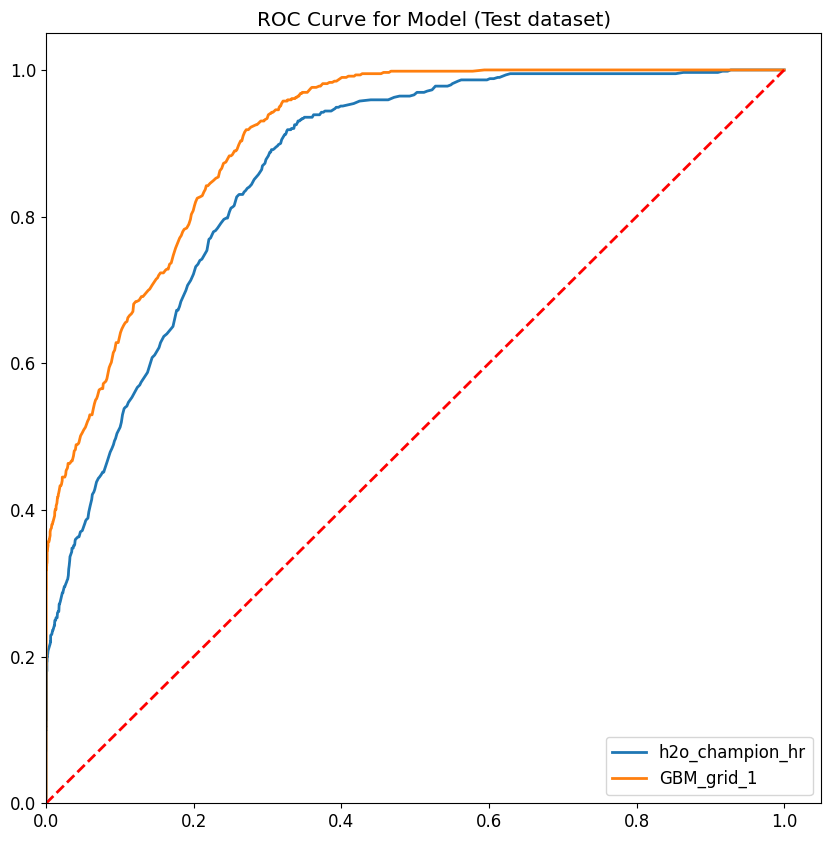

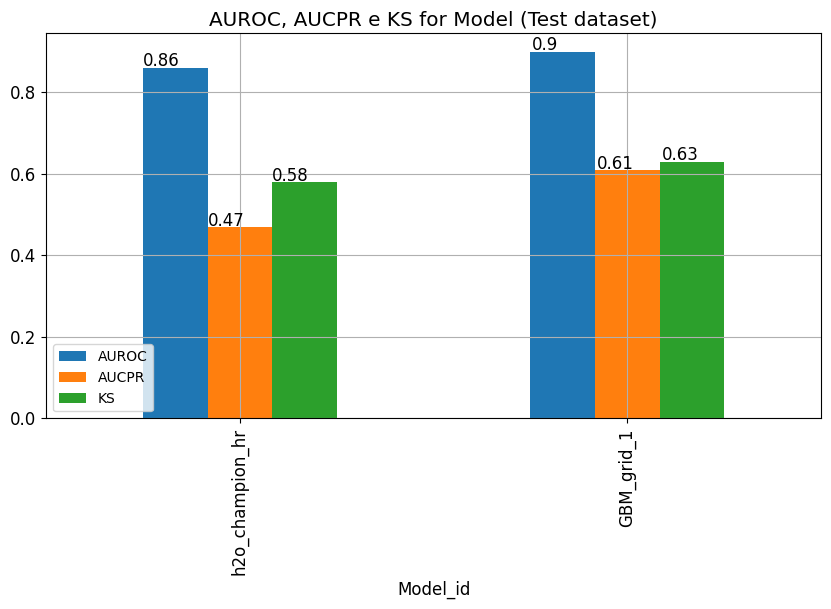

In [28]:
#Compare performance on the TEST dataset for all trained models
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(10, 10))
for i in list_models:    
    if (isinstance(i, h2o.estimators.gbm.H2OGradientBoostingEstimator)) | (isinstance(i, h2o.estimators.stackedensemble.H2OStackedEnsembleEstimator)):
        #Save all models in H20 format
        h2o.save_model(model=i, path='%s/models/candidates/' % OutputPath, force=True)
        #calculate o KS in test dataset
        h2o_predict = i.predict(test_hdf)
        data = h2o_predict.cbind(test_hdf[VarTarget]).as_data_frame()
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']    
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()

        #Ascertain the performance of all models on the test base
        performance = i.model_performance(test_hdf)

        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, i.model_id), 'w')
        f.write(
            str(i.model_id) + ";"
            + str(performance.accuracy()[0][0]) + ";"
            + str(performance.auc()) + ';'
            + str(performance.aucpr()) + ';'
            + str(performance.logloss()) + ';'
            + str(ks) + ';'
            + str(performance.F1()[0][0]))
        f.write('\n')
        f.close()

        #graph with the ROC curve of all models
        fpr = performance.fprs
        tpr = performance.tprs
        plt.plot(fpr, tpr, lw=2, label=i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2])
        plt.title("ROC Curve for Model (Test dataset)")    

        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
            
    elif isinstance(i, sagemaker.predictor.Predictor):
        #Save model
        model_id = (sm.describe_endpoint_config(EndpointConfigName=sm.describe_endpoint(EndpointName=i.endpoint_name)['EndpointConfigName'])['ProductionVariants'][0]['ModelName'])
        text_file = open("%s/models/candidates/%s.py" % (OutputPath, model_id), "w")        
        text_file.write("""#recreate create_endpoint_config and create_endpoint for model %s
epc_name = "%s"
ep_config = sm.create_endpoint_config(
    EndpointConfigName=epc_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m5.2xlarge",
            "InitialInstanceCount": 1,
            "ModelName": "%s",
            "VariantName": "main",
        }
    ],
)

#Create end endpoint
ep_name = "%s"
create_endpoint_response = sm.create_endpoint(EndpointName=ep_name, EndpointConfigName=epc_name)
sm.get_waiter("endpoint_in_service").wait(EndpointName=ep_name)
print("ep_name: " + str(ep_name))

sm_predictor = Predictor(
    endpoint_name="%s",
    sagemaker_session=session,
    serializer=CSVSerializer(),
    deserializer=CSVDeserializer(),)""" % (model_id,
                                        model_id.replace('-model', '-epc'),
                                        model_id,
                                        model_id.replace('-model', '-ep'),
                                        model_id.replace('-model', '-ep')       
                                       )
                       )
        text_file.close()
        
        sm_predict = pd.DataFrame(i.predict(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features)].to_csv(sep=",", header=False, index=False)))
        sm_predict.columns = ['predict', 'p1', 'probabilities']
        sm_predict['predict'] = sm_predict['predict'].astype(int)
        sm_predict['p1'] = sm_predict['p1'].astype(float)

        data = pd.concat([sm_predict.reset_index(drop=True), dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget]], axis=1)
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['cum_eventrate'] = kstable['cum_eventrate'].astype(float)
        kstable['cum_noneventrate'] = kstable['cum_noneventrate'].astype(float)
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()
        
        accuracy = metrics.accuracy_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        fpr, tpr, thresholds = metrics.roc_curve(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        auc = metrics.auc(fpr, tpr)
        aucpr = metrics.average_precision_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        f1 = metrics.f1_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str), pos_label='1')
        log_loss = metrics.log_loss(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        
        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, model_id), 'w')
        f.write(
            str(model_id) + ";"
            + str(accuracy) + ";"
            + str(auc) + ';'
            + str(aucpr) + ';'
            + str(log_loss) + ';'
            + str(ks) + ';'
            + str(f1))
        f.write('\n')
        f.close()
        
        plt.plot(fpr, tpr, lw=2, label=model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2])
        plt.title("ROC Curve for Model (Test dataset)")
        
        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
        
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()
plt.close()
ax = df_plot.plot(kind='bar', x="Model_id", title="AUROC, AUCPR e KS for Model (Test dataset)", grid=True, figsize=(10,5), legend=1)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.legend(loc=3, prop={'size': 10})

## 4.4 Choose the best model among all tested

In [29]:
sort_metric_best_model='F1'
#import all tested models and print the 10 bests sorted by AUC on the screen
modelos_testados = pd.concat(map(functools.partial(pd.read_csv, sep=';', header=None), glob.glob('%s/models/candidates/performance_*.csv' % OutputPath)))
modelos_testados.columns = ('model_id', 'accuracy', 'AUC', 'AUCPR', 'logloss', 'KS', 'F1')
modelos_testados = modelos_testados.sort_values(by=sort_metric_best_model, ascending=False)
modelos_testados = modelos_testados.drop_duplicates(subset=["model_id"])
print('MBest Models. Sorted by : ' + str(sort_metric_best_model))
modelos_testados.reset_index(0).head(30)

MBest Models. Sorted by : F1


,index,model_id,accuracy,AUC,AUCPR,logloss,KS,F1
0,0,GBM_grid_1_AutoML_1_20221117_34710_model_2,0.298849,0.906593,0.618806,0.176716,0.632,0.246567
1,0,GBM_grid_1_AutoML_1_20221117_20535_model_2,0.282615,0.908142,0.620116,0.175793,0.639,0.241446
2,0,GBM_grid_1_AutoML_1_20221118_00204_model_2,0.395288,0.906424,0.617342,0.177064,0.630,0.216573
3,0,h2o_champion_hr_analytics_v1_20221117_034643,0.323517,0.894360,0.566743,0.198130,0.619,0.190214
4,0,h2o_champion_hr_analytics_v1_20221117_020516,0.262877,0.883979,0.524384,0.211122,0.608,0.173404
5,0,h2o_champion_hr_analytics_v1_20221117_024546,0.262877,0.883979,0.524384,0.211122,0.608,0.173404
6,0,h2o_champion_hr_analytics_v1_20221118_000149,0.304252,0.864396,0.476487,0.226410,0.587,0.142608



BEST MODEL: GBM_grid_1_AutoML_1_20221117_34710_model_2



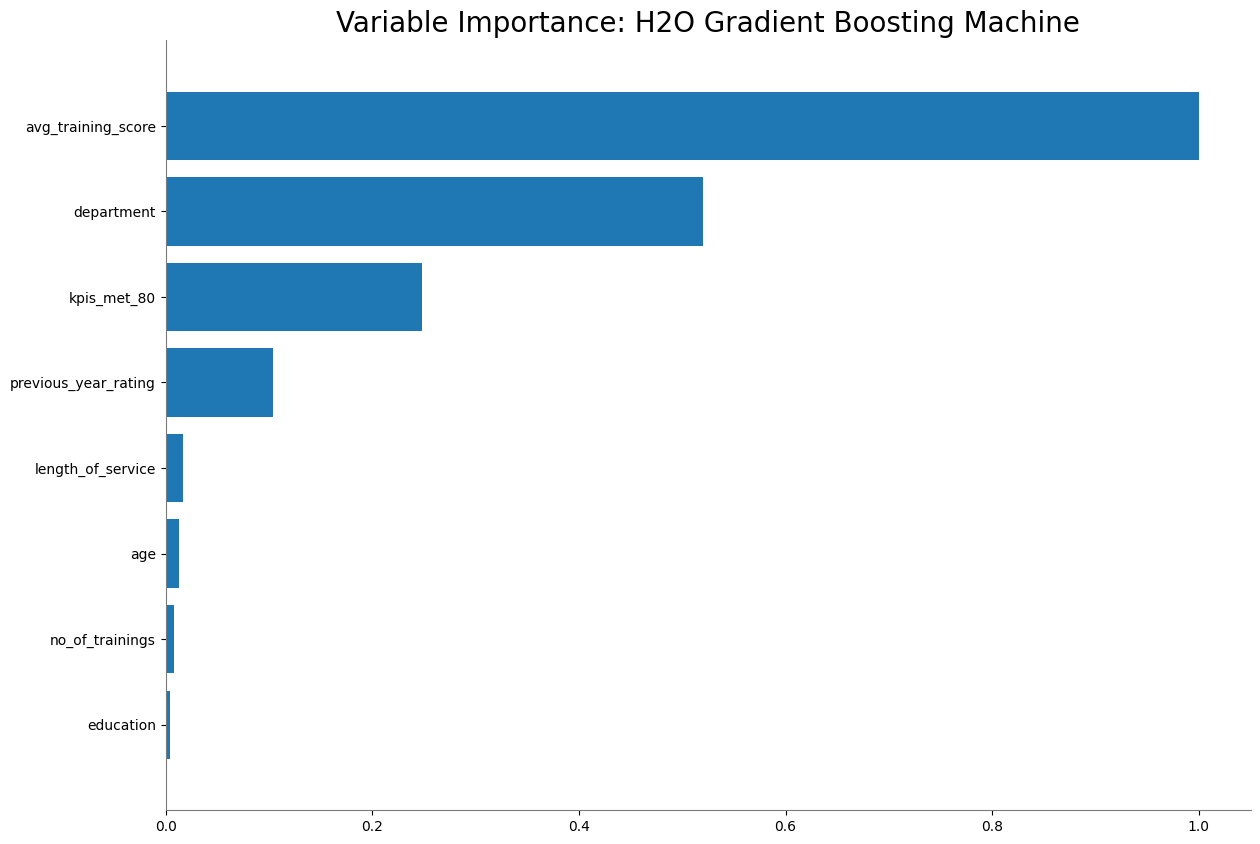

<Figure size 640x480 with 0 Axes>

In [30]:
#If you want to choose a model other than the first one on the list. Choose the position number:
posicao_melhor_modelo=0

plt.rcParams.update({'font.size': 10})
try:
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    (print("\n"+ "BEST MODEL: " + str(modelos_testados.iloc[posicao_melhor_modelo, 0]) + "\n"))
    
    melhor_modelo.varimp_plot(50)
except Exception as e:
    print(e)    
    (print("\n"+ "BEST MODEL: " + str(modelos_testados.iloc[posicao_melhor_modelo, 0]) + "\n"))
    print("Warning: This model doesn't have variable importances")

## 4.5 Stepwise for Analysis of the importance of variables and reduce the number of variables in the best model (Only for H2O)

In [31]:
#List all variables in the current model, ordered by variable importance
#For variables defined as a factor (which possibly are like dummys), remove the category from the name and leave only the orifinal name of the variable
try:
    df_features_sorted = melhor_modelo.varimp(True).variable.str.split('.', expand=True).drop_duplicates(subset = 0)[0].reset_index(drop=True).to_list()
except Exception as e:
    #As the model with ensemble in H20 does not show the importance of variables, we will include variables in selected_features
    df_features_sorted = selected_features

In [32]:
#Define the number of variables to be increased with each new model. Try to put 10% or 20% of the total, as it can take a long time
qt_var=1
qt_total_var = len(df_features_sorted)

dict_model_tmp={}
dict_performance={}

for i in range(qt_var, qt_total_var+qt_var, qt_var):    
    df_features_sorted[0:i]
    
    #If no model chosen is not an ensemble of models. Then use the same model for training with increment of variables
    melhor_modelo_tmp = melhor_modelo
    if melhor_modelo_tmp.model_id.lower().find("ensemble") == -1:
        dict_model_tmp[i] = melhor_modelo_tmp
        dict_model_tmp[i].train(x = df_features_sorted[0:i],
                                y = VarTarget,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)
    ##If it is not possible, for the home of an ensemble of models, use GradientBoostingEstimator to make the assessment
    else:
        dict_model_tmp[i] = H2OGradientBoostingEstimator(seed=1, model_id=str('model_tmp_%s' % i))
        dict_model_tmp[i].train(x = df_features_sorted[0:i],
                                y = VarTarget,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)       


    perform_oot = dict_model_tmp[i].model_performance(test_hdf)
    dict_performance_tmp = {}
    dict_performance_tmp['AUC'] = {'qt_var': i, 'medida': 'AUC', 'Validation_Dataset': dict_model_tmp[i].auc(valid=True), 'Test_Dataset': perform_oot.auc()}
    dict_performance_tmp['accuracy'] = {'qt_var': i, 'medida': 'accuracy', 'Validation_Dataset': dict_model_tmp[i].accuracy(valid=True)[0][0], 'Test_Dataset': perform_oot.accuracy()[0][0]}
    dict_performance_tmp['AUCPR'] = {'qt_var': i, 'medida': 'AUCPR', 'Validation_Dataset': dict_model_tmp[i].aucpr(valid=True), 'Test_Dataset': perform_oot.aucpr()}
    dict_performance_tmp['F1'] = {'qt_var': i, 'medida': 'F1', 'Validation_Dataset': dict_model_tmp[i].F1(valid=True)[0][0], 'Test_Dataset': perform_oot.F1()[0][0]}
    dict_performance_tmp['logloss'] = {'qt_var': i, 'medida': 'logloss', 'Validation_Dataset': dict_model_tmp[i].logloss(valid=True), 'Test_Dataset': perform_oot.logloss()}
    dict_performance[i] = pd.DataFrame(dict_performance_tmp).transpose()

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


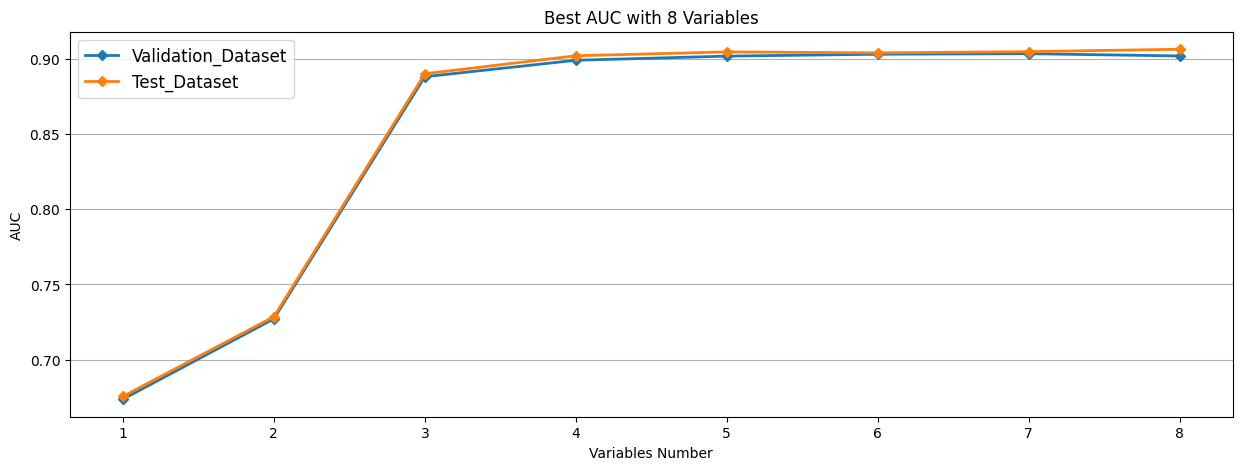

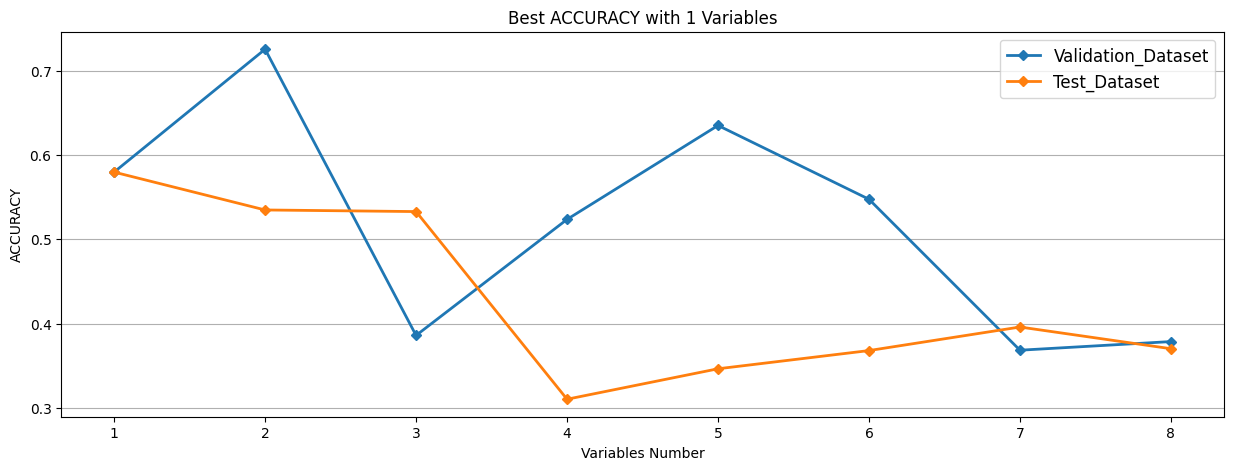

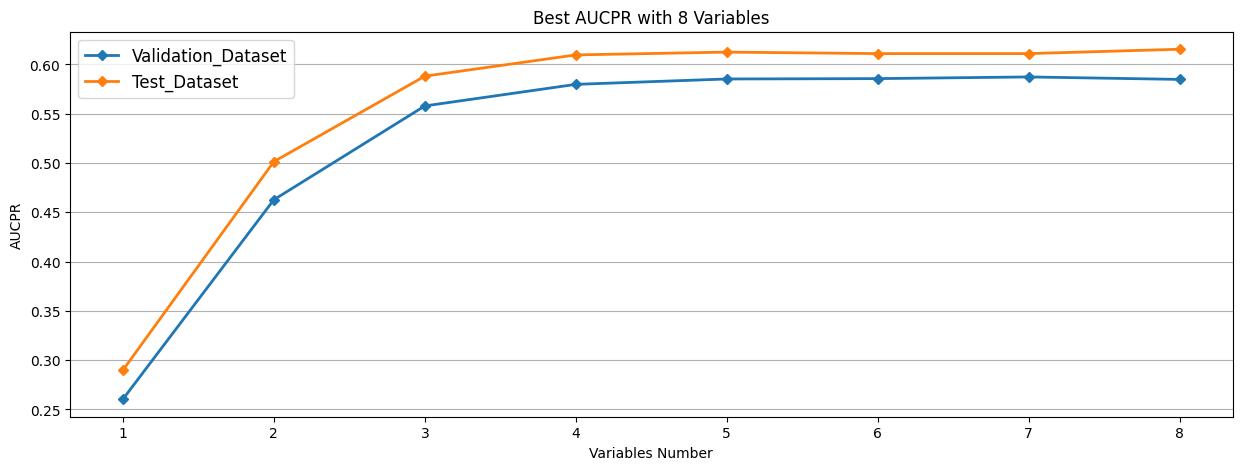

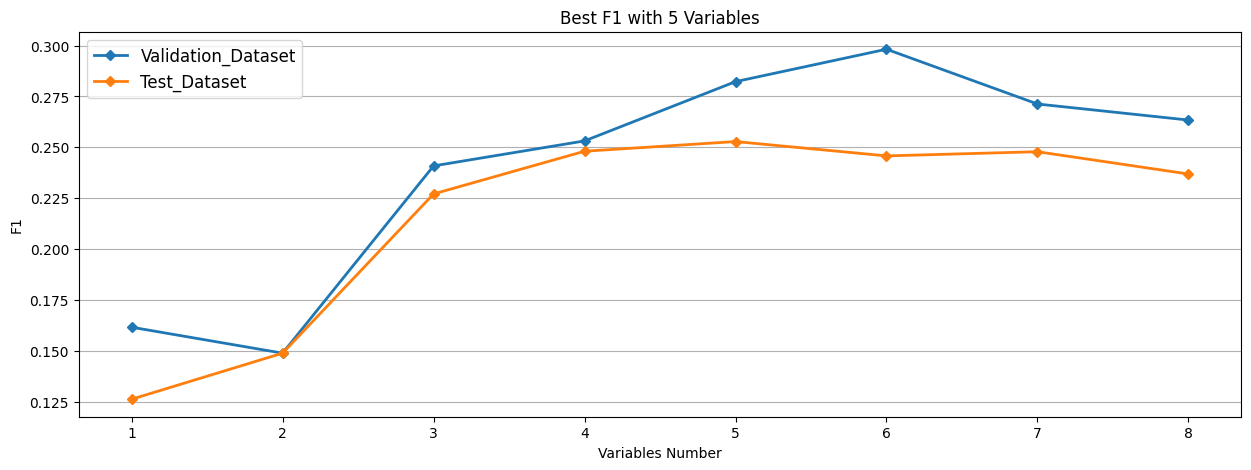

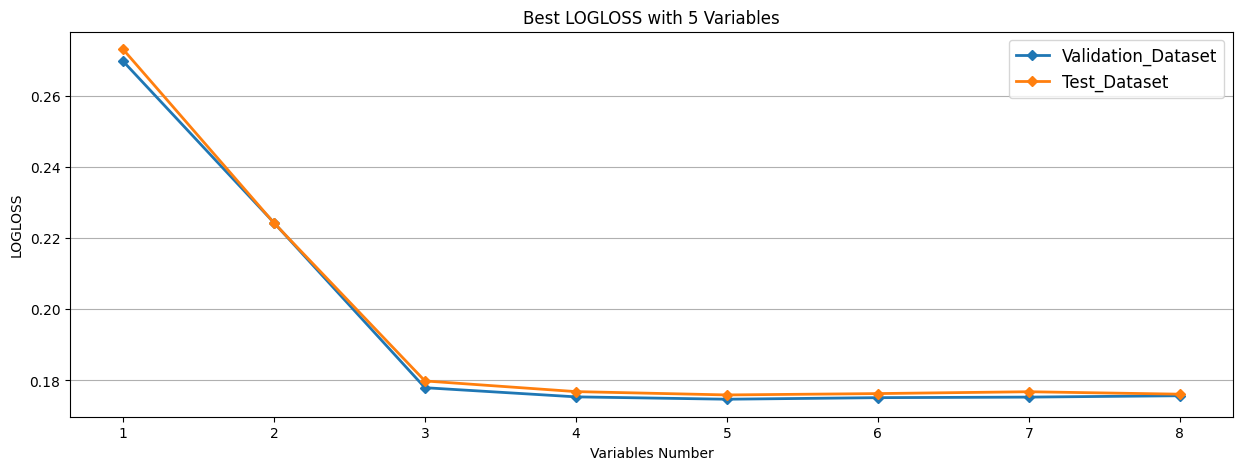

In [33]:
##Plot graph comparing the increase in performance with the increase in variables
for i in dict_performance.keys():
    if i == list(dict_performance.keys())[0]:
        df_performance = dict_performance[i]
    else:
        df_performance = df_performance.append(dict_performance[i], ignore_index=True)

lista_metricas_perf = df_performance['medida'].unique()

for i in range(len(lista_metricas_perf)):   
    #selects only the metric to be analyzed
    metrics_df_tmp = df_performance.query('medida == "%s"' % lista_metricas_perf[i])
    metrics_df_tmp = metrics_df_tmp.set_index('qt_var')
    del metrics_df_tmp['medida']
    if lista_metricas_perf[i] == 'logloss':
        max_oot = metrics_df_tmp[metrics_df_tmp['Test_Dataset'] == metrics_df_tmp.Test_Dataset.min()].index.values
    else:
        max_oot = metrics_df_tmp[metrics_df_tmp['Test_Dataset'] == metrics_df_tmp.Test_Dataset.max()].index.values
        
    if lista_metricas_perf[i] == sort_metric_best_model:
        max_oot_filtro = max_oot[0]        
    
    ax=metrics_df_tmp.plot(figsize=(15,5), linewidth=2, fontsize=10, marker='D', ms=5,\
                            title='Best %s with %s Variables' % (lista_metricas_perf[i].upper(), str(max_oot[0])))
    plt.xlabel('Variables Number')
    plt.ylabel('%s' % lista_metricas_perf[i].upper())
    plt.grid(axis='y')
    plt.legend(loc=0, prop={'size': 12})
    #display(ax)

In [34]:
print('Consider using only the following variables: '+ str(df_features_sorted[0:int(max_oot_filtro)]))

Consider using only the following variables: ['avg_training_score', 'department', 'kpis_met_80', 'previous_year_rating', 'length_of_service']


# 5. Exporting the best model to Deploy (Usar o path_model_mojo para o código 3_Explaining_Model.ipynb)

In [35]:
try:
    #Save the H2O model in MOJO format and all the variables of the best model
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    path_model_mojo = melhor_modelo.download_mojo('%s/models/best/' % OutputPath, get_genmodel_jar=True)
    print('path_model_mojo: ' + str(path_model_mojo))
    caminho_modelo_h2o = h2o.save_model(model=melhor_modelo, path='%s/models/best/' % OutputPath, force=True)
except Exception as e:
    src_path = "%s/models/candidates/%s.py" % (OutputPath, ModelId)
    dst_path = "%s/models/best/%s.py" % (OutputPath, ModelId)
    shutil.copy(src_path, dst_path)
    print('path_sagemaker_model: ' + str(dst_path))

path_model_mojo: /home/sagemaker-user/FIEP-Modelos-de-Aprendizado-e-Arquiteturas-Cloud/avaliacao/output_model/models/best/GBM_grid_1_AutoML_1_20221117_34710_model_2.zip


Detected 1 unused columns in the input data set: {}


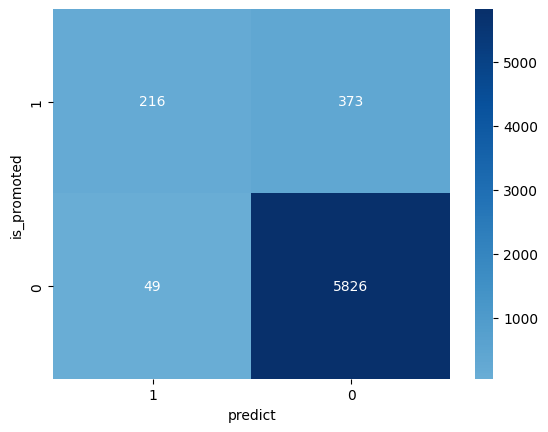

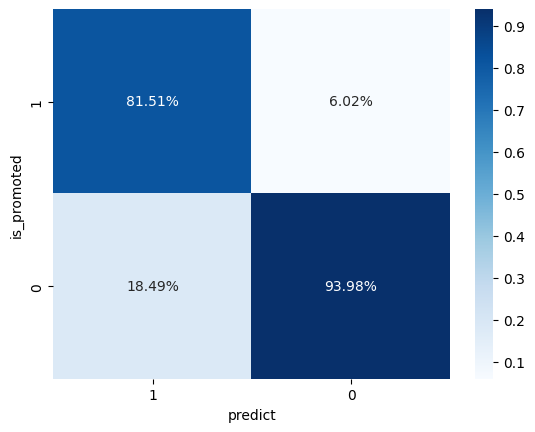

In [36]:
#Confusion Matrix for the Champion
df_predict_tmp = h2o.mojo_predict_pandas(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])], mojo_zip_path=path_model_mojo, verbose=False)

df_predict = pd.concat([df_predict_tmp.reset_index(drop=True), dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])].reset_index(drop=True)], axis=1)

df_matrix = df_predict.reset_index().groupby([VarTarget, 'predict']).count()[['index']].reset_index().pivot(index=VarTarget, columns='predict', values='index').sort_values(by=[VarTarget], ascending=False).loc[:,(1,0)]

sns.heatmap(df_matrix, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_matrix/np.sum(df_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

## 5.1 Cleaning Resources

In [37]:
# sm.delete_endpoint(EndpointName=ep_name)
# sm.delete_endpoint_config(EndpointConfigName=epc_name)

# 6. Save final dataset with predictions into S3 to explain the model

In [38]:
csv_buffer = StringIO()
df_predict.to_csv(csv_buffer, index=False, header=True)
s3_resource = my_boto3_session.resource('s3')
s3_resource.Object(bucket, 'databases/%s/%s.csv' % (ModelName+'_scored', ModelName+'_scored')).put(Body=csv_buffer.getvalue())
del csv_buffer

In [39]:
glue = my_boto3_session.client('glue', region_name="us-east-1")

try:
    glue.delete_table(
        DatabaseName='auladeploymodelos',
        Name=ModelName+'_scored'
    )
except:
    print("table does not exist e sera criada pela primeira vez")

glue.update_crawler(Name='aula-deploy-modelos',
                    Targets={'S3Targets': [{'Path': 's3://%s/databases/%s' % (bucket, ModelName+'_scored'),
                               'Exclusions': []}]})

glue.start_crawler(Name='aula-deploy-modelos')

table does not exist e sera criada pela primeira vez


{'ResponseMetadata': {'RequestId': 'e553535e-a799-4b03-82ad-6acf9830d915',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Fri, 18 Nov 2022 00:31:45 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'e553535e-a799-4b03-82ad-6acf9830d915'},
  'RetryAttempts': 0}}